In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module_CFG import Data_Module_CFG
from Models.Experimental_Model import TexModel
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pytorch_lightning.callbacks import ModelCheckpoint

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.is_available()

False

In [3]:


class CFG:
    
    device = dev
    
   
    use_wandb = True
    
    ######### Dataset #########
    
    # stage: 'train' or 'test'
    stage = 'train'
    set_max_label_length = 128
    number_png_images_to_use_in_dataset=250*1000
    labels_transform='default'
    image_transform_name ='alb'
    train_val_fraction = 0.97
    vocabulary_path = 'Tokenizer/230k_ver2.json'
    load_vocabulary = True
    image_padding = True
    max_width = 1024


    batch_size = 16
    num_workers = 0
    on_gpu = False
    
    ######## Model and Lightning Model paramters ############
    
    # MODEL
    max_label_length = 128
    
    embedding_dim = 256
    decoder_heads = 16
    decoder_layers = 6
    decoder_dropout = 0.2
    decoder_fc = 512
    
    
    learning_rate =  1e-4
    
    
    
    checkpoint = None
    save_directory = None
    
    
    accumulate_grad_batches = 64 // batch_size  # experiments showed batch_size * accumulate_grad = 192 is optimal
   
    eta_min = 1e-8
    t_max = 40
    max_epochs = 35
    weight_decay =  1e-5
    precision =16
    
    # checkpointing
    save_top_k=5
    
    monitor="FBETA"
    mode="max"
    
    
    ####### Augemtnations/ Image Transforms ###############
    
    # Training Aug
    
    train_transforms = [
       #A.augmentations.geometric.resize.Resize(height=64, width= 512, p=1),
                        #A.ShiftScaleRotate(shift_limit=0, scale_limit=(-.15, 0), rotate_limit=1, border_mode=0, interpolation=3, value=[255, 255, 255], p=1),
                        #A.Affine(scale=(0.6, 1.0), rotate=(-2, 2), cval=255, p=0.5),
                        #A.GridDistortion(distort_limit=0.1, border_mode=0, interpolation=3, value=[255, 255, 255], p=.5),
                        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
                        A.GaussianBlur(blur_limit=(1, 1), p=0.5),
                        A.RandomBrightnessContrast(.5, (-.5, .5), True, p=0.3),
                        #A.ImageCompression(95, p=.3),
                        ToTensorV2(),
                        ]
    

    
    # Validaiton Aug
    
    val_transforms = [
        #A.Resize(patch_size, patch_size),
    #A.augmentations.geometric.resize.Resize(height=64, width= 512, p=1),
         A.Normalize(
            mean= [0] * 3,
            std= [1] *3
        ),
        A.augmentations.transforms.ToGray(p=1),
       
        ToTensorV2(),
    ]
    
    # Test Aug
    test_transforms = [
        #A.Resize(patch_size, patch_size),
      

        ToTensorV2(),
    ]
        
    
    

In [4]:
dataset = Data_Module_CFG(cfg=CFG)

Train/Val Data is ready for Model loading.


In [5]:
#Helper Function to convert prediction labels to strings
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s + str(letter)
    return s



transform = transforms.ToPILImage()

In [6]:
model = TexModel(dataset=dataset,cfg =CFG).to(dev)
model.load_state_dict(torch.load(("Models_Parameters_Log/experimental_last_1.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
lit_model.eval()
lit_model.freeze()
scripted_save = lit_model.to_torchscript()
torch.jit.save(scripted_save, "Models_Parameters_Log/scripted_model1.pt")


/Users/gregory/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
scripted = torch.jit.load("Models_Parameters_Log/scripted_model1.pt")

In [8]:
import albumentations
from albumentations.augmentations.geometric.resize import Resize
import torch.nn.functional as F

MAX_RATIO = 8
GOAL_HEIGHT = 128

def find_ratio(h, w, goal):
    return goal/h
    


def predict(image_path):
   
    image = cv2.imread(image_path)
    image =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.bitwise_not(image)
    
    h, w, c = image.shape
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
        
    new_h = GOAL_HEIGHT
    new_w = int(new_h * ratio)
    image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = dataset.val_transform(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    
    max_H = 128
    max_W = 1024

    image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)

    
    print(image_tensor.shape)
    print(display(transform(image_tensor)))
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))



In [9]:
IMAGES= [#'Jupyter_Notebooks/test_photos/79a37d9d8b727e9.png',
         #"Jupyter_Notebooks/test_photos/S201.png",
          #"Jupyter_Notebooks/test_photos/202.png",
           "Jupyter_Notebooks/test_photos/203.png",
         "Jupyter_Notebooks/test_photos/qqq.png",
         "Jupyter_Notebooks/test_photos/zarhin.png",
         "Jupyter_Notebooks/test_photos/my_image.png",
         "Jupyter_Notebooks/test_photos/screenshot_1.png",
         "Jupyter_Notebooks/test_photos/screenshot_3.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_14.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_10.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_13.png",
          "Jupyter_Notebooks/test_photos/Screen Shot_11.png",
         "Jupyter_Notebooks/test_photos/screenshot_2.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_18.png",
        'Jupyter_Notebooks/test_photos/128.png',
         'Jupyter_Notebooks/test_photos/128_2.png',
         'Jupyter_Notebooks/test_photos/image_3.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_15.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_11.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_16.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_17.png',
         'Jupyter_Notebooks/test_photos/screenshot_2.png',
         'Jupyter_Notebooks/test_photos/ratio25.png',
         'Jupyter_Notebooks/test_photos/ratio31.png',
        'Jupyter_Notebooks/test_photos/ratio76.png',
         
    

]

(128, 380, 3)


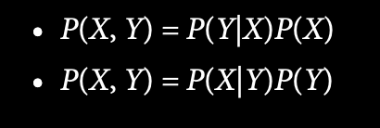

None
torch.Size([1, 128, 1024])


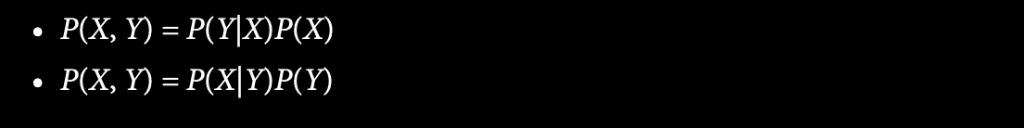

None

Predicted formula:
<S>\begin{array}{ll}{}&{{}^{-1}F(X,Y)=F(X)Y(\Sigma)}\\{}&{{}}&{{}}&{{}{}F(X,Y)={\calP}(\Sigma)Y(Y)}\\\end{array}<E><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P>


<IPython.core.display.Math object>

None
(128, 555, 3)


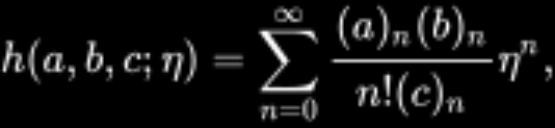

None
torch.Size([1, 128, 1024])


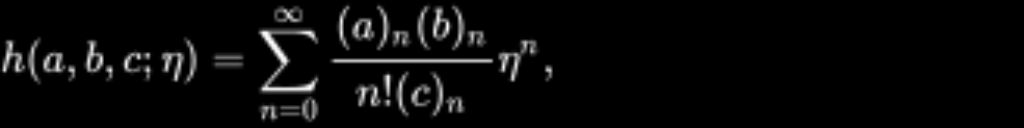

None

Predicted formula:
<S>h(a,b,c;\eta)=\sum_{n=0}^{\infty}\frac{(a)_{n}(b)_{n}}{n!(c)_{n}}\eta^{n},<E><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P>


<IPython.core.display.Math object>

None
(128, 569, 3)


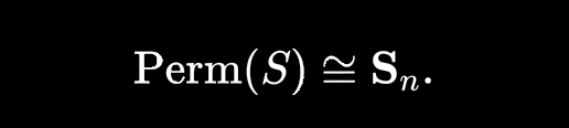

None
torch.Size([1, 128, 1024])


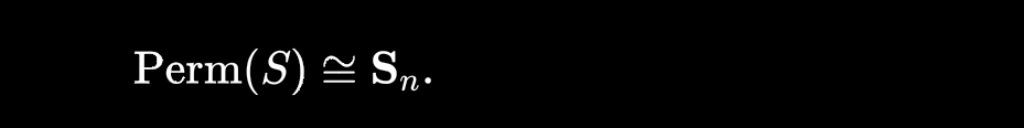

None

Predicted formula:
<S>\mathrm{~~~~~~~~~~~~~~~\mathrm{~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


<IPython.core.display.Math object>

None
(128, 484, 3)


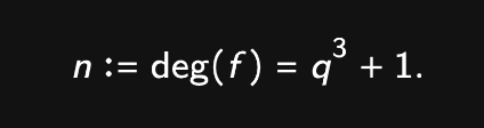

None
torch.Size([1, 128, 1024])


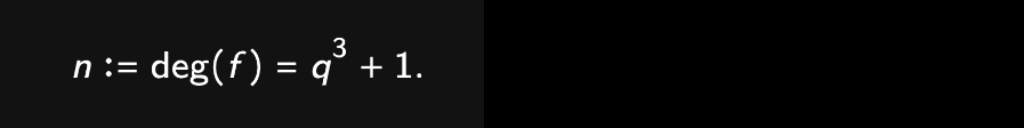

None

Predicted formula:
<S>\qquada_{n}=\mathrm{deg}(\tau)=q^{3}+1.<E><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P>


<IPython.core.display.Math object>

None
(128, 554, 3)


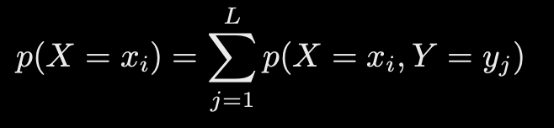

None
torch.Size([1, 128, 1024])


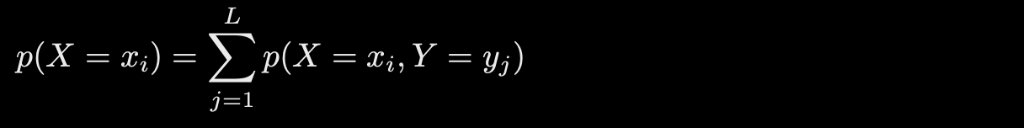

None

Predicted formula:
<S>p(X-x_{i})=\sum_{j=1}^{L}p(X-x_{i}Y-y_{i})<E><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P>


<IPython.core.display.Math object>

None
(128, 432, 3)


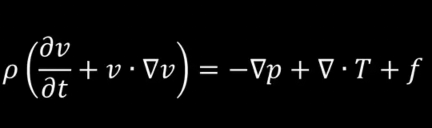

None
torch.Size([1, 128, 1024])


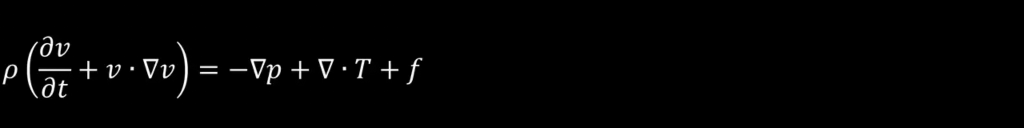

None

Predicted formula:
<S>\rho\frac{\partial_{r}}{\partialt}+r^{r}Y_{r})=-(m-N-r)\cdotr+f<E><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P>


<IPython.core.display.Math object>

None
(128, 911, 3)


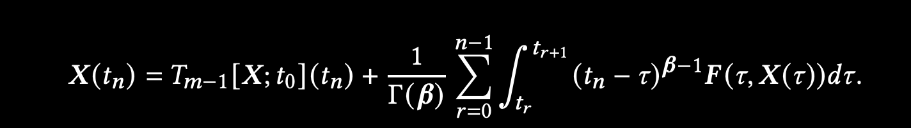

None
torch.Size([1, 128, 1024])


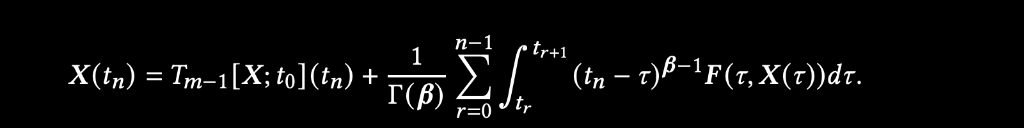

None

Predicted formula:
<S>{\calI}={\calX}({\calI}_{a})=T_{abc}({\bfX})\mathrm{Tr}({\bfZ})\,{\frac{1}{4}}\prod_{I=1}^{N}\int_{I_{I}}^{K_{I}}({\bfg},-{\bfX})^{\beta-1}{\calI}({\bfg},{\bfK})\,dr.<E><P><P><P><P><P><P><P><P><P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


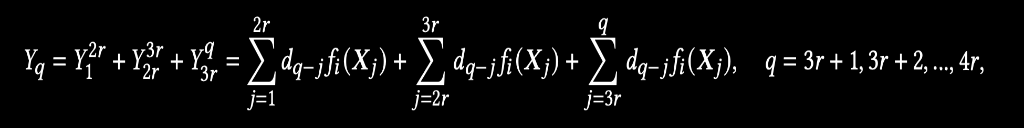

None
torch.Size([1, 128, 1024])


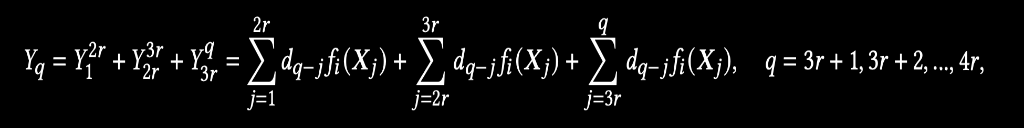

None

Predicted formula:
<S>|^{m}|\Omega_{j}^{m}|\Omega_{j}^{m}|^{M}|\Psi_{j}^{j}|^{j}|X_{j}\rangle|^{j}|\sum_{j=1}^{N}\phi_{j}|f(X)|^{j}\rangle_{j}^{j}|\phi(X)|^{j}\rangle=\sum_{m}^{N}\psi_{j}|j(X)|^{j}


<IPython.core.display.Math object>

None
(128, 1024, 3)


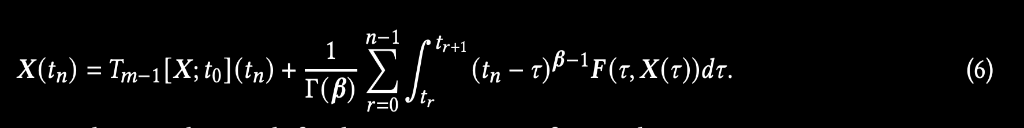

None
torch.Size([1, 128, 1024])


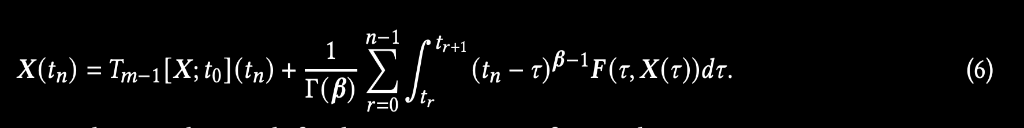

None

Predicted formula:
<S>|X(y)|=|x|^{2}|A|\Omega|0\rangle|t|t|^{2}\frac{1}{\Gamma_{0}^{2}}\int_{t}^{\infty}e_{t}-f^{s}e_{tt}(t)X(t)A(t)dt.<E><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P>


<IPython.core.display.Math object>

None
(128, 270, 3)


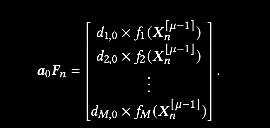

None
torch.Size([1, 128, 1024])


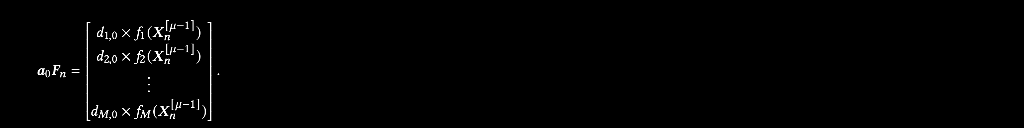

None

Predicted formula:
<S>\begin{array}{ccc}{}&{}&{}&{}&{}&{}\\{}&{}&{}&{}&{}&{}\\{}&{}&{}&{}&{}&{}&{}\\{}&{}&{}&{}&{}&{}&{}\\{}&{}&{}&{}&{}&{}&{}&{}&{}\\{}&{}&{}&{}&{}&{}&


<IPython.core.display.Math object>

None
(128, 582, 3)


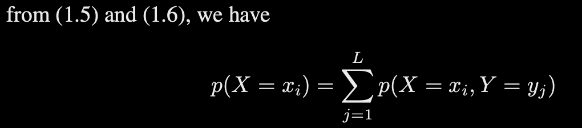

None
torch.Size([1, 128, 1024])


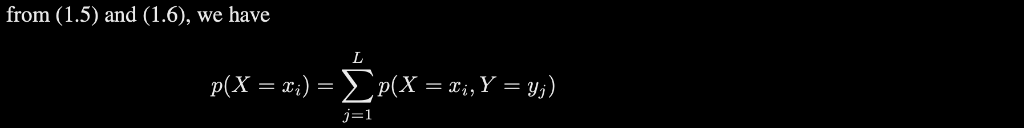

None

Predicted formula:
<S>\begin{array}{ll}{\mathrm{for}(1)\mathrm{for}}&{\mathrm{for}}\\{}&{}&{\mathrm{for}(1-i)\mathrm{for}}&{}\\{}&{}&{}&{\mathrm{for}(1-i_{1})^{2}}&{}&{}&{}&{}&{}&{}&{}&{}\\\end{array}<E><P><P><P><P><P><P><P><P><P><P><P>


<IPython.core.display.Math object>

None
(128, 768, 3)


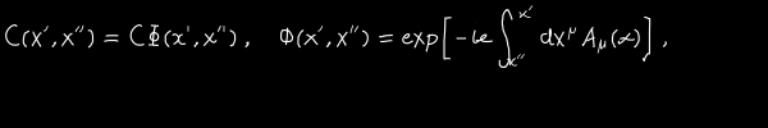

None
torch.Size([1, 128, 1024])


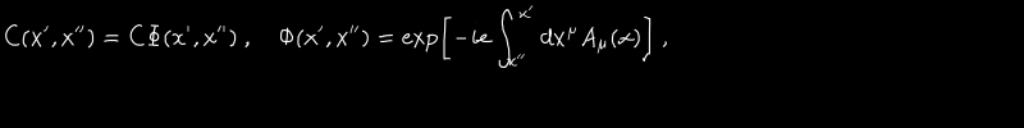

None

Predicted formula:
<S>\zeta(z^{2}z^{2})=e^{-i\alpha(z^{2}z^{2})-et(z^{2})^{2}-e^{-i\alpha^{2}}z^{2}A^{2}A_{i}(z^{2}z)}.<E><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P>


<IPython.core.display.Math object>

None
(128, 228, 3)


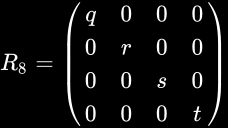

None
torch.Size([1, 128, 1024])


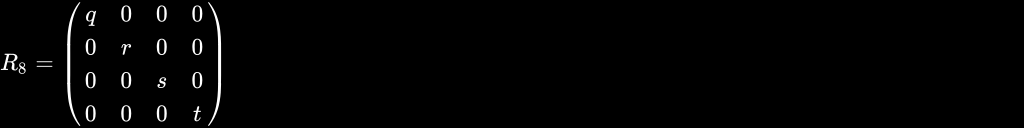

None

Predicted formula:
<S>R_{2}=\left(\begin{array}{ccccc}{I}&{0}&{0}&{0}\\{0}&{I}&{0}&{0}\\{0}&{0}&{I}&{0}&{0}\\{0}&{0}&{0}&{0}&{0}\\\end{array}\right)<E><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


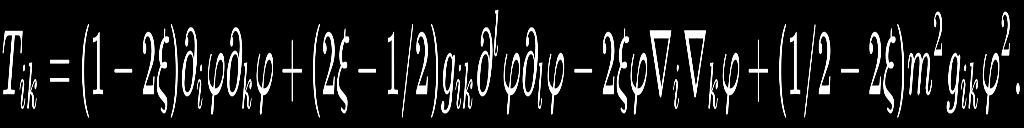

None
torch.Size([1, 128, 1024])


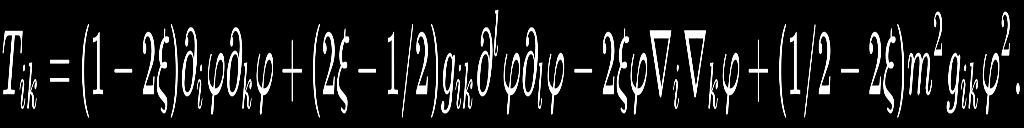

None

Predicted formula:
<S>\prod_{\{j\}}^{1}=\left[1\right]\prod_{j}^{N}[0]_{j}^{N}|\psi_{j}^{N}=\left[\frac{1}{2}\left[\frac{1}{2}\right]_{j}^{N}\prod_{j}^{N}\left[\frac{1}{\sqrt{2}}\right]_{j^{N}}^{N}\prod_{j^{N}}^{N}\prod_{j^{j^{N}}


<IPython.core.display.Math object>

None
(128, 727, 3)


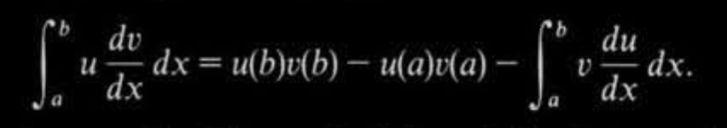

None
torch.Size([1, 128, 1024])


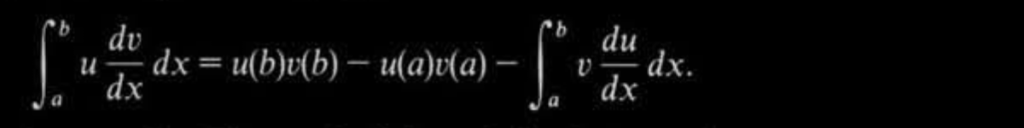

None

Predicted formula:
<S>=\left[\int_{s}^{2}d{\frac{d\sigma}{ds}}d\chi=u(\theta)|t\rangle+u(dy)(d)=\left[\int_{s}^{2}v{\frac{du}{dz}}d\chi.<E><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P>


<IPython.core.display.Math object>

None
(128, 949, 3)


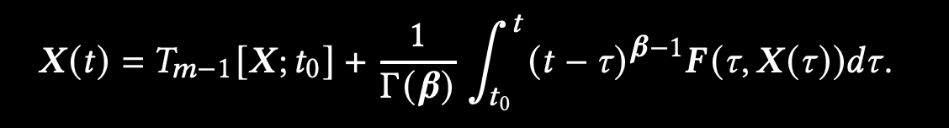

None
torch.Size([1, 128, 1024])


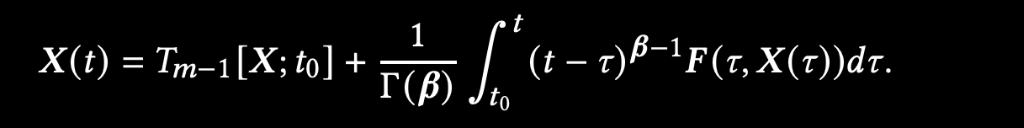

None

Predicted formula:
<S>=X(t)=T_{m+1}[X;t]+\frac{1}{\Gamma(\theta)}\int_{t_{0}}^{L}(t-i)^{F-1}F(\tau,X(\tau))d\tau.<E><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P>


<IPython.core.display.Math object>

None
(128, 270, 3)


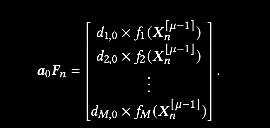

None
torch.Size([1, 128, 1024])


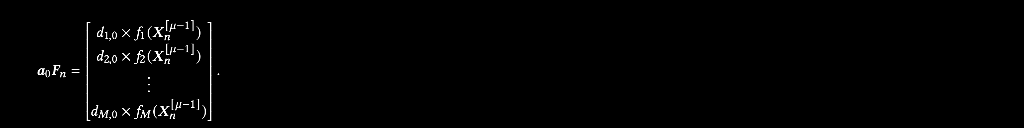

None

Predicted formula:
<S>\begin{array}{ccc}{}&{}&{}&{}&{}&{}\\{}&{}&{}&{}&{}&{}\\{}&{}&{}&{}&{}&{}&{}\\{}&{}&{}&{}&{}&{}&{}\\{}&{}&{}&{}&{}&{}&{}&{}&{}\\{}&{}&{}&{}&{}&{}&


<IPython.core.display.Math object>

None
(128, 768, 3)


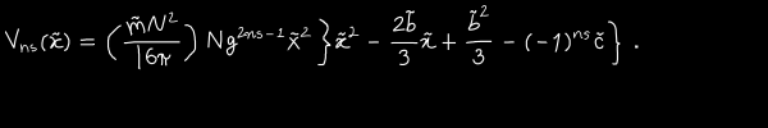

None
torch.Size([1, 128, 1024])


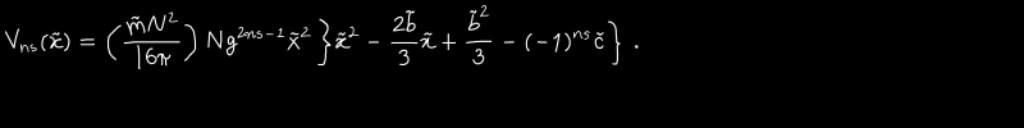

None

Predicted formula:
<S>\chi_{n}(z)=\left(\frac{3\sqrt{2\pi}}{4\pii}\right)\mathrm{s}^{n-1/2}\,\mathrm{str}\,\frac{\beta^{2}\pi+\frac{\beta}{3}+\frac{\beta}{3}\,(-\gamma^{2})^{2}s}{s}\,(-\gamma^{2})^{2}s+s^{2}s}\,.<E><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P>


<IPython.core.display.Math object>

None
(128, 768, 3)


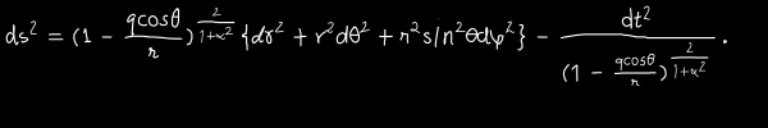

None
torch.Size([1, 128, 1024])


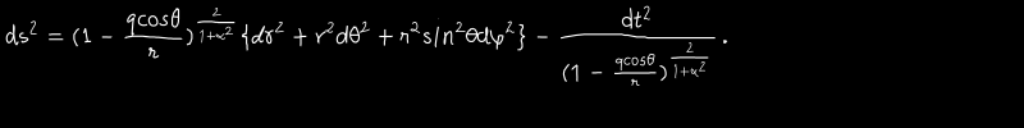

None

Predicted formula:
<S>A^{2}=\alpha^{-2}\frac{e^{-2}\frac{e^{2}}{2\pi}\frac{e^{2}}{e^{2}-e^{2}}\left[A^{2}+e^{2}e^{2}+e^{2}e^{2}\right]^{-\frac{1}{2}}}{(1+e^{2})e^{-\frac{1}{2\pi}}(1-e^{2})^{2


<IPython.core.display.Math object>

None
(128, 582, 3)


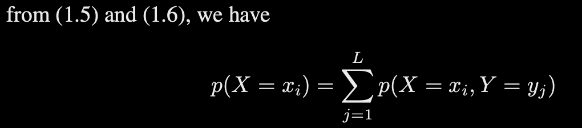

None
torch.Size([1, 128, 1024])


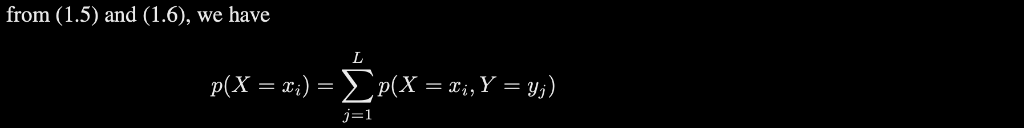

None

Predicted formula:
<S>\begin{array}{ll}{\mathrm{for}(1)\mathrm{for}}&{\mathrm{for}}\\{}&{}&{\mathrm{for}(1-i)\mathrm{for}}&{}\\{}&{}&{}&{\mathrm{for}(1-i_{1})^{2}}&{}&{}&{}&{}&{}&{}&{}&{}\\\end{array}<E><P><P><P><P><P><P><P><P><P><P><P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


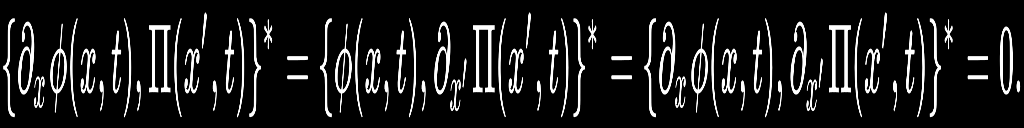

None
torch.Size([1, 128, 1024])


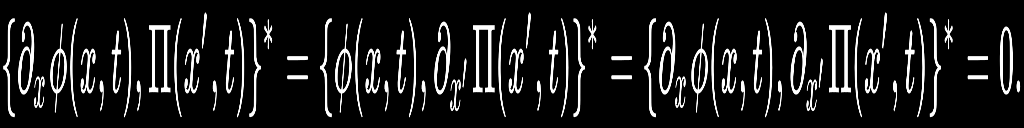

None

Predicted formula:
<S>|\left\{\begin{cases}{\prod_{i}^{1}}|\prod_{j_{j}^{\prime}}^{1}|\prod_{j_{j}^{\prime}}^{1}|\prod_{j_{j}^{\prime}}^{1}|\prod_{j_{j}^{\prime}}^{1}|\prod_{j_{j^{\prime}}^{\prime}}\prod_{j_{j^{\prime}}^{\prime}|\prod_{j_{j^


<IPython.core.display.Math object>

None
(128, 1024, 3)


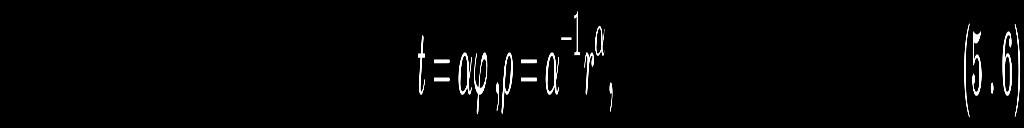

None
torch.Size([1, 128, 1024])


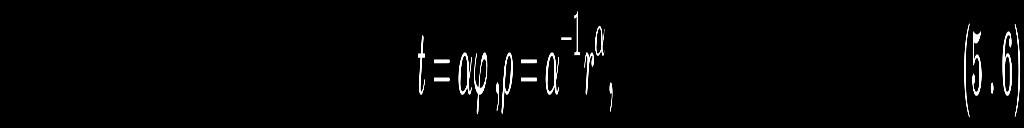

None

Predicted formula:
<S>{\calH}\,,\qquad\qquad\qquad\left\{\begin{array}{cc}{1}&{0}\\{1}&{0}&{0}\\{1}&{0}&{0}\\\end{array}\right\}^{1}\frac{1}{1},<E><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P><P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


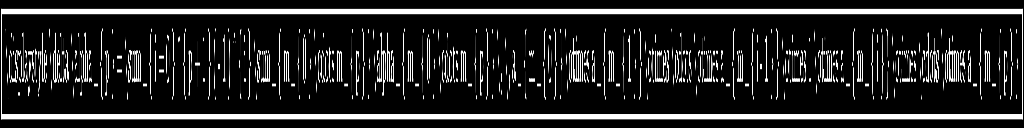

None
torch.Size([1, 128, 1024])


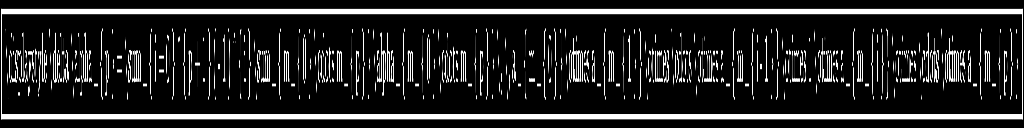

None

Predicted formula:
<S>\left[\underbrace{\left[\xi\right]\left[\frac{1}{2}\left[\left[\frac{1}{\sqrt{2}\left[\left[\frac{1}{2}\right]^{2}\left[\left[\left[\left[\left[\left[\frac{1}{2}\right]\right]\right]\left[\left[\left[\left[\left[\frac{1}{2}\right]\right]\right]\left[\left[\left[\left[\frac{1}{2}\right]\right]\right]\right]\left[\left[\frac{1}{2}\right]\right]\left[\left[\frac{1}{2}\right]\right]\left[\left[\frac{1}{2}\right]\right]\right]\right]\right]\right]\left[\frac{1}{2


<IPython.core.display.Math object>

None


In [10]:
for image in IMAGES:
    predict(image)

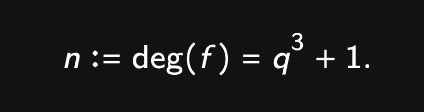

None

Predicted formula:
<S>\begin{array}{ll}{}&{}&{}&{}&{}&{}&{}&{}&{}&{}\\{}&{}&{}&{}&{}&{}&{}&{}&{}&{}\\{}&{}&{}&{}&{}&{}&{}&{}&{}&{}&{}\\{}&{}&{}&{}&{}&{}&{}&{}&{}&{}&{


<IPython.core.display.Math object>

None


In [11]:
my_image_path= "Jupyter_Notebooks/test_photos/my_image.png"
my_image = cv2.imread(my_image_path)
my_image =  cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
my_image= cv2.bitwise_not(my_image)
#my_image = PIL.ImageOps.invert(my_image)

my_image_tensor = dataset.val_transform(image=np.array(my_image))['image']
print(display(transform(my_image_tensor)))
print('\nPredicted formula:')
with torch.no_grad():
    model.eval()
    my_prediction =  model.predict(my_image_tensor.unsqueeze(0).to('cpu'))
print(token_to_strings(my_prediction))
print(display(Math(token_to_strings(my_prediction))))

In [12]:
my_image_tensor.unsqueeze(0).shape

torch.Size([1, 3, 112, 424])

In [13]:
model.unet(my_image_tensor.unsqueeze(0).float())

tensor([[[[-8.9605e-01,  1.5479e-01, -4.1461e-02,  ..., -1.0716e-03,
           -1.0716e-03, -4.8027e-04],
          [ 1.6893e+00, -3.0095e-01,  1.6342e-01,  ..., -2.7519e-04,
           -2.7519e-04, -5.5787e-04],
          [-7.1239e-02, -3.3430e-01,  3.1741e-01,  ..., -2.7519e-04,
           -2.7519e-04, -5.5787e-04],
          ...,
          [ 4.3324e-03, -2.7519e-04, -2.7519e-04,  ..., -2.7519e-04,
           -2.7519e-04, -5.5787e-04],
          [ 4.3324e-03, -2.7519e-04, -2.7519e-04,  ..., -2.7519e-04,
           -2.7519e-04, -5.5787e-04],
          [ 2.0136e-03, -3.2898e-03, -3.2898e-03,  ..., -3.2898e-03,
           -3.2898e-03, -2.4968e-03]],

         [[-9.0634e-01, -2.6818e-01,  2.4841e-01,  ..., -6.3221e-03,
           -6.3221e-03, -7.3637e-03],
          [-4.7425e-01, -6.2230e-03,  6.8234e-02,  ..., -7.1316e-03,
           -7.1316e-03, -8.1429e-03],
          [ 1.2910e-01,  2.0461e-01, -1.4617e-01,  ..., -7.1316e-03,
           -7.1316e-03, -8.1429e-03],
          ...,
     

In [14]:
model.unet

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(8, 8), padding=(1, 1), bias=False)
          (adn): ADN(
            (N): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.1, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(3, 256, kernel_size=(3, 3), stride=(8, 8), padding=(1, 1), bias=False)
    )
    (1): SkipConnection(
      (submodule): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (adn): ADN(
              (N): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.1, inplace=False)
              (A): PReLU(num_parameters=1)
            )
        